In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime
import math 
import QuantLib as ql
from scipy.optimize import minimize

dataframe = "NASDAQ"

df = pd.DataFrame()

eonia_rates = pd.read_csv(r'eonia1.csv', sep=";")

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)

current_time = current_price = ATM_price = None
if dataframe == "NASDAQ":
    df = pd.read_csv(r'Nasdaq_optionChain_100821_1915.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
    df["IV"] = df["IV"]/100
    df["IV (P)"] = df["IV (P)"]/100

    # Remove strikes from Dataframe
    fltr = [140., 145., 150., 155., 160., 165., 170., 175., 180., 185., 190., 195., 200., 210., 220.]
    df = df[df['Strike'].isin(fltr)]

    current_time = pd.Timestamp(year=2021, month=8, day=10, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 188.68
    ATM_price = 190.

elif dataframe == "SPX":
    df = pd.read_csv(r'spx_SABR.csv')
    df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')

    # Remove IV=0 strikes from Dataframe
    fltr = df[df["IV"] <= 0.]["Strike"].unique()
    df = df[~df['Strike'].isin(fltr)]
    df = df[~(df['Strike'] <= 3000)]

    current_time = pd.Timestamp(year=2021, month=8, day=3, hour=12)
    today = date_pd_to_ql(current_time)
    current_price = 4300.
    ATM_price = 4300.

maturities = df["Date"].unique()
strikes = df["Strike"].unique()

ql.Settings.instance().evaluationDate = today
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))
rate = ql.SimpleQuote(-0.00482)
riskFreeCurve = ql.FlatForward(today, ql.QuoteHandle(rate), ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)

vols = [np.array(df[df["Date"] == maturities[m]]["IV"]) for m in range(len(maturities))]

plot_size = (12, 5)

dates = [date_pd_to_ql(d) for d in maturities]

Tenors   Rate
0    0.25 -0.575
1    1.00 -0.557
2    3.00 -0.549
3    6.00 -0.529
4   12.00 -0.494

TypeError: 'str' object is not callable

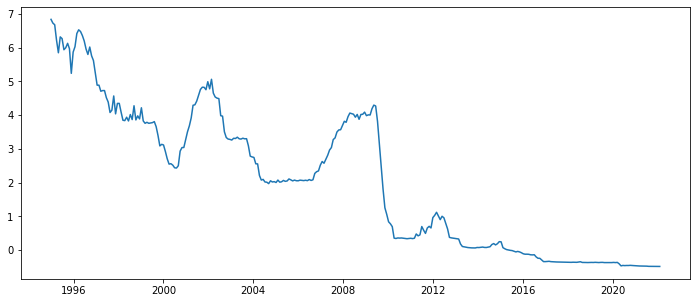

In [83]:
# Spot rates table and chart (EONIA)

rates = [-0.575, -0.557, -0.549, -0.529, -0.494]
tenors = [.25, 1, 3, 6, 12]

spot_rates = pd.DataFrame({"Tenors": tenors, "Spot Rate": rates})
spot_rates.set_index('Tenors')

display(spot_rates)

fig = plt.figure(figsize=(12,5))
dates = [datetime.date(1994, 12, 31) + datetime.timedelta(days=30*n) for n in range(len(eonia_rates['value']))]
plt.plot(dates, eonia_rates['value'])
plt.title("EONIA Rates (%) 1996-2021")

In [40]:
#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, (dates[-1] - today) / 365., 0.1), plot_strikes=strikes, funct='blackVol', title="", size=plot_size):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(title)
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)

def plot_smile(date, smiles, bounds=None, market=True, title="", size=(15, 4)):

    market_vols = vols[dates.index(date)]

    fig, ax = plt.subplots(figsize=size)
    for smile in smiles:
        ax.plot(strikes, smile[0], label=smile[1])
    if market:
        ax.plot(strikes, market_vols, "rX", label="Actual")
        ax.plot([ATM_price], market_vols[strikes.tolist().index(ATM_price)], "o", label="ATM")
    
    if bounds:
        ax.set_xbound(bounds[0], bounds[1])
        
    ax.set_title(title)
    ax.set_xlabel("Strikes", size=12)
    ax.set_ylabel("Vols", size=12)
    legend = ax.legend(loc="upper right")

# Plot Volatility Smile Comparisons

def smiles_comparison(models, heston_models=[], points=(.2, .5, .75, 1)):
        for i in [round((len(dates)-1) * x) for x in points]:
                tenor = dates[i]
                l = [([model.vol_surface.blackVol(tenor, s) for s in strikes], model.label) for model in models]
                if len(heston_models) > 0:
                        l.extend([([x.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston" ) for x in heston_models])

                plot_smile(tenor, l, title="Volatility Smile for options expiring on {}".format(tenor))


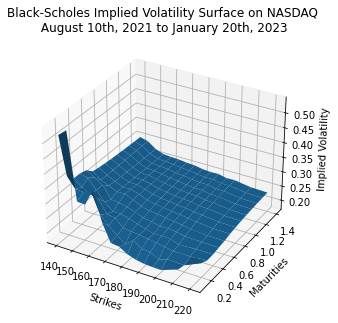

In [41]:
# BLACK VOLATILITY SURFACE

volMatrix = ql.Matrix(len(strikes), len(dates))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

black_var_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()

title = "Black-Scholes Implied Volatility Surface on {}\n {} to {}".format(dataframe, today, dates[-1])
plot_vol_surface(vol_surface=black_var_surface, plot_strikes=strikes, funct='blackVol', title=title)

In [42]:
#CALIBRATE VOLATILITY SURFACE

class SABRSmile:
    def __init__(self, date, shift=0, beta=1, method="normal", fwd=current_price):
        self.date = date
        self.expiryTime = round((self.date - today)/365, 6)
        self.marketVols = vols[dates.index(self.date)]
        self.shift = shift
        self.fwd = fwd
        self.alpha=None; self.beta = beta; self.nu=None; self.rho=None
        self.method = method
        self.current_price = current_price
        self.newVols = None
        self.error = None

    def initialize(self):
        # alpha, beta, nu, rho
        cons = (
        {'type': 'ineq', 'fun': lambda x: x[0] - 0.001},
        {'type': 'ineq', 'fun': lambda x: x[2] - 0.001},
        {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2},
        )

        x = self.set_init_conds()

        result = minimize(self.f, x, constraints=cons, method="SLSQP")
        self.error = result['fun']
        [self.alpha, self.beta, self.nu, self.rho] = result['x']

        self.newVols = [self.vols_by_method(strike, self.alpha, self.beta, self.nu, self.rho) for strike in strikes]

    def set_beta(self):
        return self.beta
    
    def set_init_conds (self):
        if self.beta >= .5:
            return [.1, self.beta, .1, .1]
        else:
            return [.1, self.beta, .1, .1]

    def vols_by_method(self, strike, alpha, beta, nu, rho):
        if self.method == "floch-kennedy":
            return ql.sabrFlochKennedyVolatility(strike, self.fwd, self.expiryTime, alpha, beta, nu, rho)
        elif self.shift != 0:
            return ql.shiftedSabrVolatility(strike, self.fwd, self.expiryTime, alpha, beta, nu, rho, self.shift)
        else:
            return ql.sabrVolatility(strike, self.fwd, self.expiryTime, alpha, beta, nu, rho)

    def f(self, params):

        alpha, beta, nu, rho = params

        beta = self.beta
        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) # Avoid rhp going < -1.0
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([self.vols_by_method(strike, alpha, beta, nu, rho) for strike in strikes])

        self.error = ((vols - np.array(self.marketVols))**2 ).mean() **.5

        return self.error


class SABRVolatilitySurface:
    def __init__(self, method="normal", beta=1, shift=0, fwd=current_price, label=""):
        self.method = method
        self._beta = beta
        self.shift = shift
        self.fwd = fwd
        self.label = label

        self.initialize()

    def initialize(self):
        self.vol_surface_vector, self.errors, self.alpha, self.beta, self.nu, self.rho = [], [], [], [], [], []
        self.SABRVolMatrix, self.SABRVolDiffMatrix = (ql.Matrix(len(strikes), len(dates)), ql.Matrix(len(strikes), len(dates)))
        
        for i, d in enumerate(dates):
            volSABR = SABRSmile(date=d, beta=self._beta, shift=self.shift, method=self.method, fwd=self.fwd)
            volSABR.initialize()

            self.alpha.append(volSABR.alpha)
            self.beta.append(volSABR.beta)
            self.nu.append(volSABR.nu)
            self.rho.append(volSABR.rho)
            
            self.errors.append(volSABR.error)

            smile = volSABR.newVols

            self.vol_surface_vector.extend(smile)

            #constructing the SABRVolatilityMatrix
            for j in range(len(smile)):
                self.SABRVolMatrix[j][i] = smile[j]
                self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]
            
            self.vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, self.SABRVolMatrix, day_count)
            self.vol_surface.enableExtrapolation()

    def to_dataframe(self):
        d = {'alpha': self.alpha, 'beta': self.beta, 'nu': self.nu, 'rho': self.rho}
        return pd.DataFrame(data=d, index=dates)


# Backbone modelling for SABR
def SABR_backbone_plot (beta=1, bounds=None, shift=0, fixes=(.95, 1, 1.14, 1.24), tenor=dates[2]):
    l = []
    for i in fixes:
        vol_surface = SABRVolatilitySurface(method="normal", shift=current_price*shift, beta=beta, fwd=current_price * i)
        SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, vol_surface.SABRVolMatrix, day_count)
        SABR_vol_surface.enableExtrapolation()

        l.append( ([SABR_vol_surface.blackVol(tenor, s) for s in strikes], "fwd = {}".format(current_price * i) ) )
        
    plot_smile(tenor, l, bounds=bounds, market=False, title="backbone, beta = {}, {}".format(vol_surface.beta[0], tenor))

C:\Users\somig\AppData\Local\Temp/ipykernel_16772/3206371925.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]


alpha  beta         nu       rho
August 20th, 2021     0.136912   1.0  12.963712 -0.994987
September 17th, 2021  0.136937   1.0   3.677440 -0.231623
October 15th, 2021    0.169243   1.0   2.263193 -0.277232
November 19th, 2021   0.195223   1.0   1.619780 -0.304001
December 17th, 2021   0.197674   1.0   1.445803 -0.310927
January 21st, 2022    0.195221   1.0   1.522237 -0.257295
March 18th, 2022      0.220948   1.0   0.980765 -0.361758
January 20th, 2023    0.237486   1.0   0.703659 -0.278507

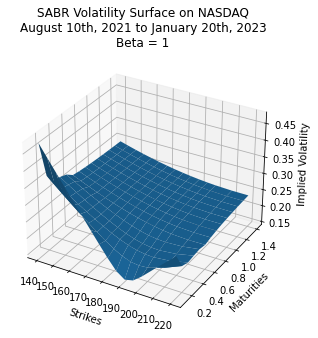

In [43]:
#SABR VOLATILITY SURFACE

volatility_surface = SABRVolatilitySurface()
SABRVolMatrix = volatility_surface.SABRVolMatrix

SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

title = "SABR Volatility Surface on {}\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface(vol_surface=SABR_vol_surface, title=title)

volatility_surface.to_dataframe()

C:\Users\somig\AppData\Local\Temp/ipykernel_16772/3206371925.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]


C:\Users\somig\AppData\Local\Temp/ipykernel_16772/3206371925.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]
C:\Users\somig\AppData\Local\Temp/ipykernel_16772/3206371925.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]


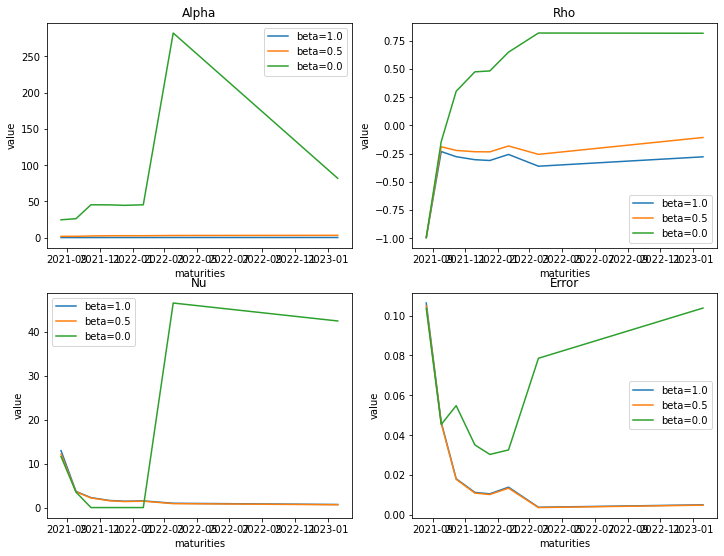

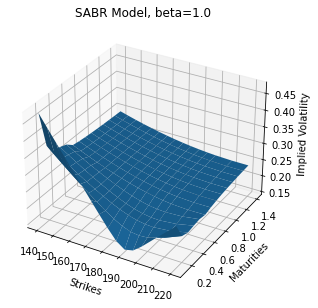

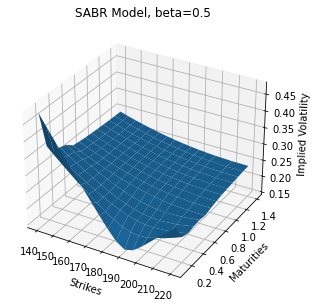

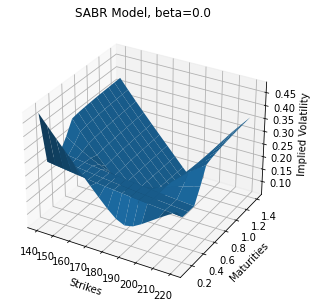

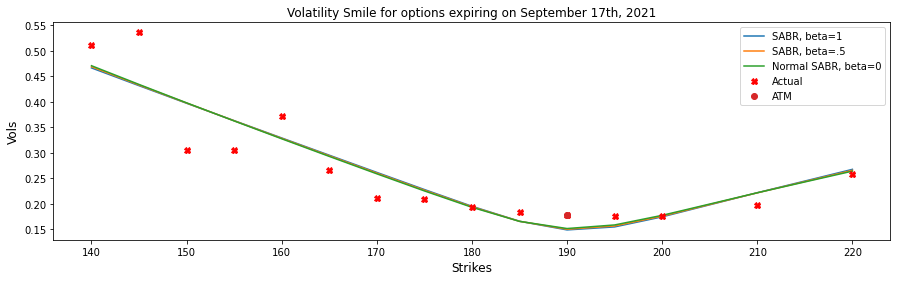

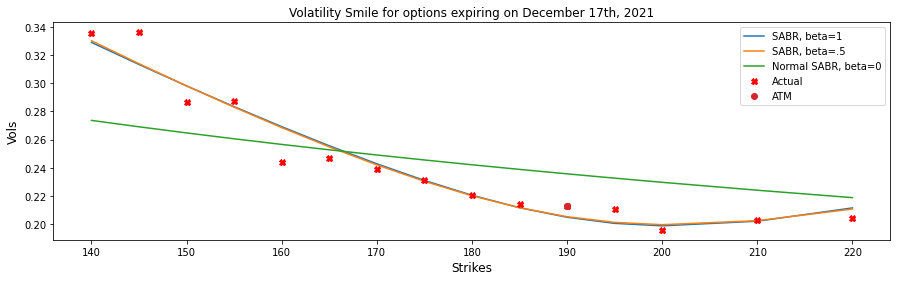

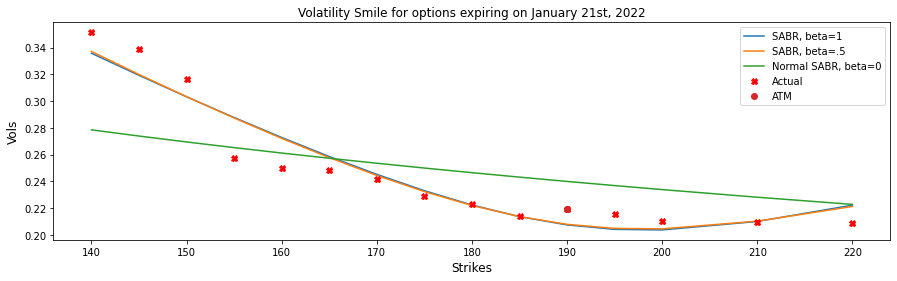

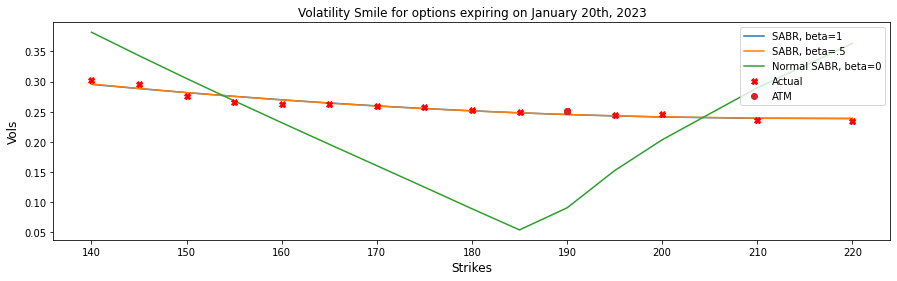

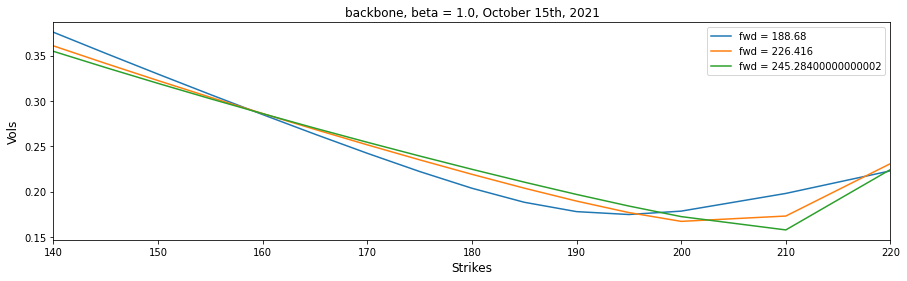

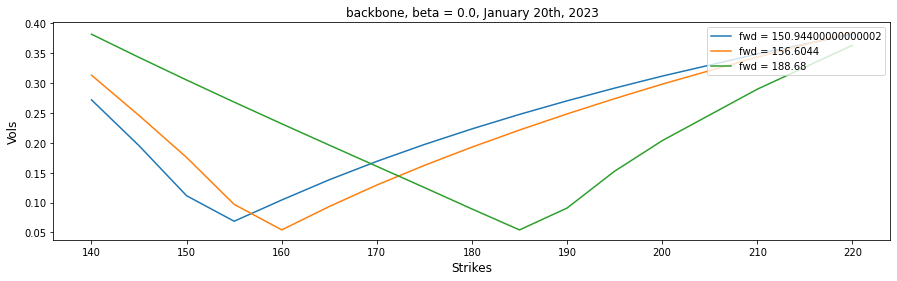

In [63]:
# SABR Volatility model

SABR_beta1 = SABRVolatilitySurface(beta=1, shift=0, label="SABR, beta=1")
SABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, label="SABR, beta=.5")
SABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, label="Normal SABR, beta=0")

def SABRComparison(methods, title=""):
    fig, axs = plt.subplots(2, 2, figsize=plot_size)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
    for method in methods:
        lbl = "beta={}".format(method.beta[1])
        axs[0, 0].plot(maturities, method.alpha, label=lbl)
        axs[0, 0].set_title('Alpha')
        axs[0, 0].set(xlabel='maturities', ylabel='value')
        axs[0, 0].legend()
        axs[1, 0].plot(maturities, method.nu, label=lbl)
        axs[1, 0].set_title('Nu')
        axs[1, 0].set(xlabel='maturities', ylabel='value')
        axs[1, 0].legend()
        axs[0, 1].plot(maturities, method.rho, label=lbl)
        axs[0, 1].set_title('Rho')
        axs[0, 1].set(xlabel='maturities', ylabel='value')
        axs[0, 1].legend()
        axs[1, 1].plot(maturities, method.errors, label=lbl)
        axs[1, 1].set_title('Error')
        axs[1, 1].set(xlabel='maturities', ylabel='value')
        axs[1, 1].legend()
        
        method_df = method.to_dataframe()
        display(method_df.style.set_caption("SABR, {}".format(lbl)))

        plot_vol_surface(method.vol_surface, title="{}, {}".format(title, lbl))

    smiles_comparison(methods)

        
SABRComparison([SABR_beta1, SABR_beta5, SABR_beta0], title="SABR Model")

# SABR Backbone modelling
fix = (1, 1.2, 1.3) if dataframe == "NASDAQ" else (1, 1.03, 1.06)
b = (current_price*.95, current_price*1.07) if dataframe == "SPX" else (strikes[0], strikes[-1])
SABR_backbone_plot(fixes = fix, bounds=b)
SABR_backbone_plot(beta=0, fixes = (.8, .83, 1), tenor = dates[-1])

C:\Users\somig\AppData\Local\Temp/ipykernel_16772/3206371925.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]


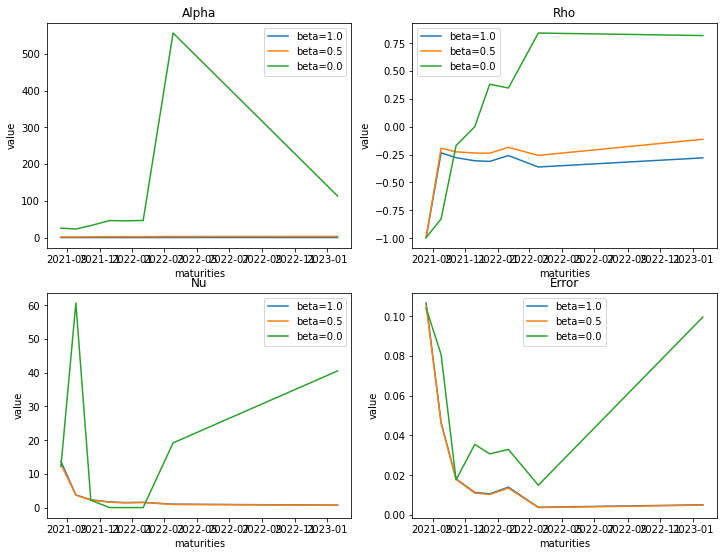

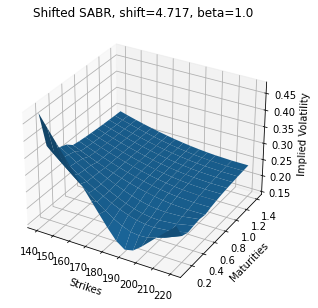

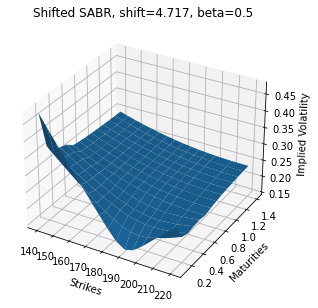

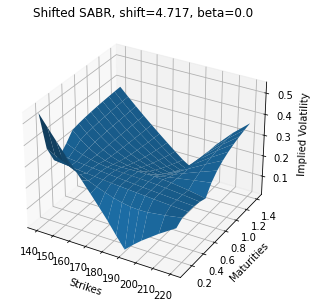

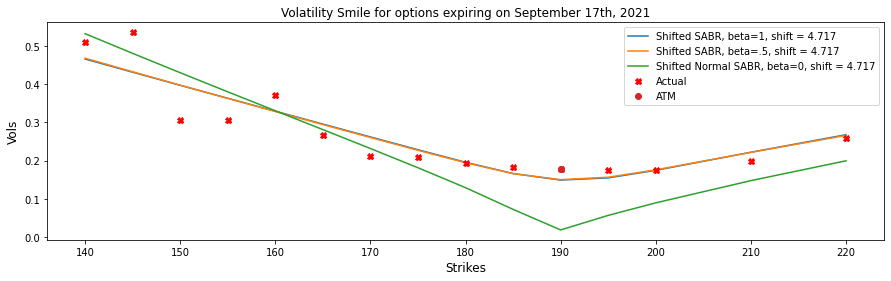

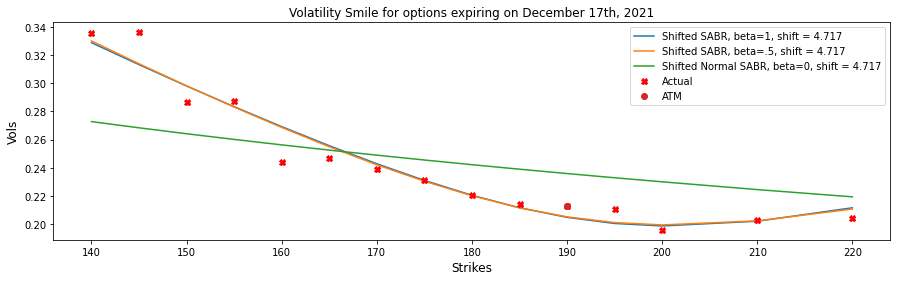

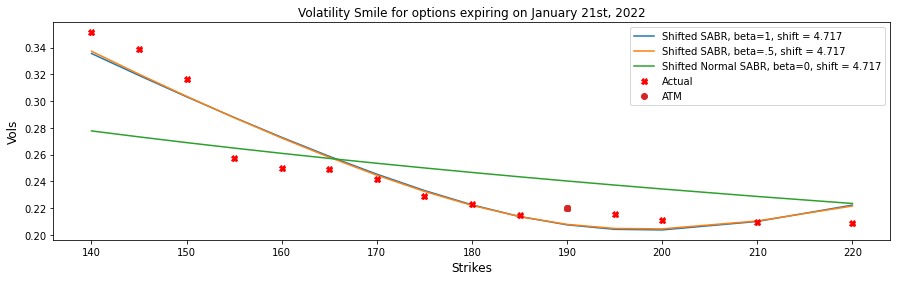

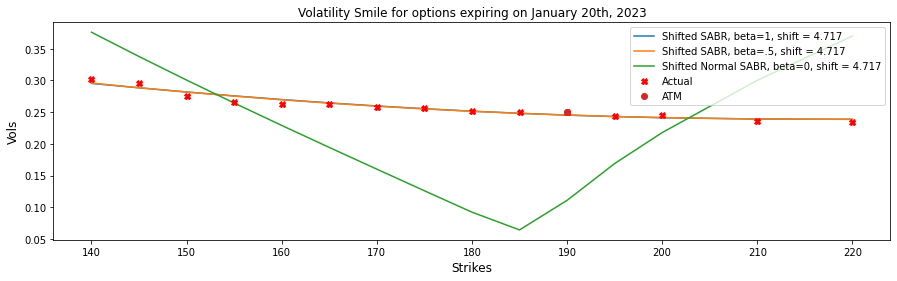

In [64]:
# Shifted SABR Volatility model
shft = .025 * current_price
shiftedSABR_beta1 = SABRVolatilitySurface(beta=1, shift=shft, label="Shifted SABR, beta=1, shift = {}".format(round(shft, 4)))
shiftedSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=shft, label="Shifted SABR, beta=.5, shift = {}".format(round(shft, 4)))
shiftedSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=shft, label="Shifted Normal SABR, beta=0, shift = {}".format(round(shft, 4)))

SABRComparison([shiftedSABR_beta1, shiftedSABR_beta5, shiftedSABR_beta0], title="Shifted SABR, shift={}".format(round(shft, 4)))

C:\Users\somig\AppData\Local\Temp/ipykernel_16772/3206371925.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]


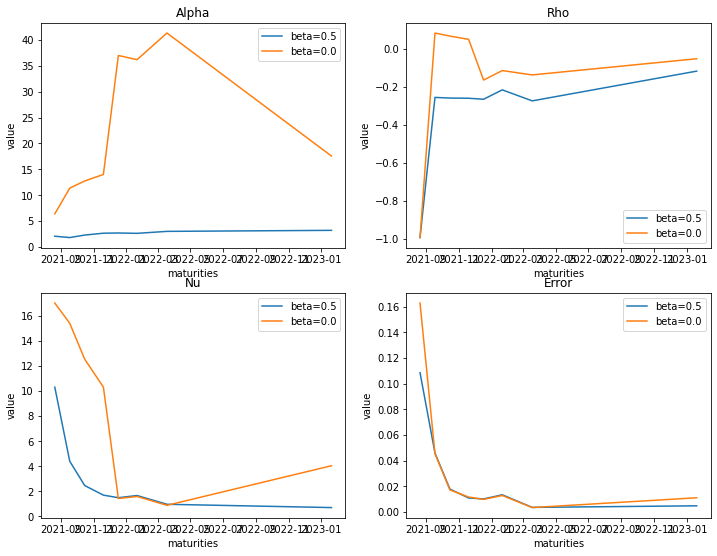

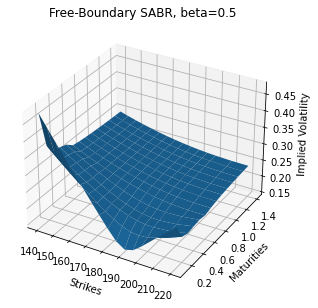

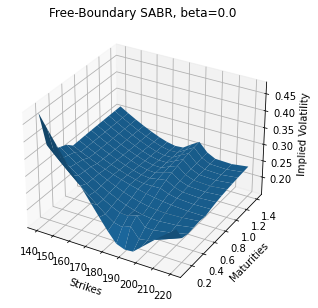

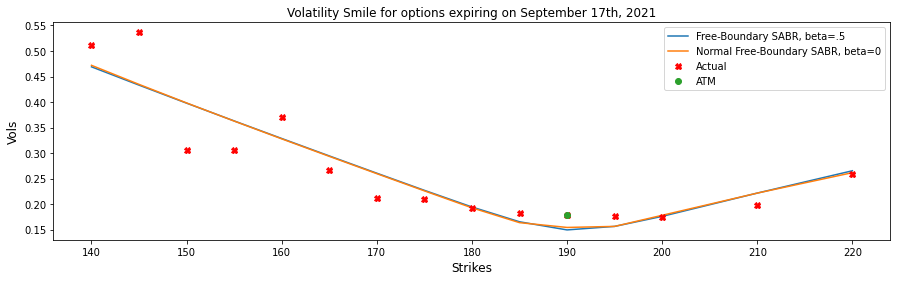

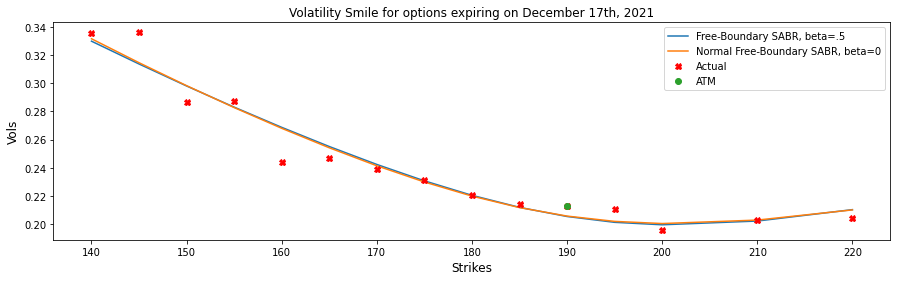

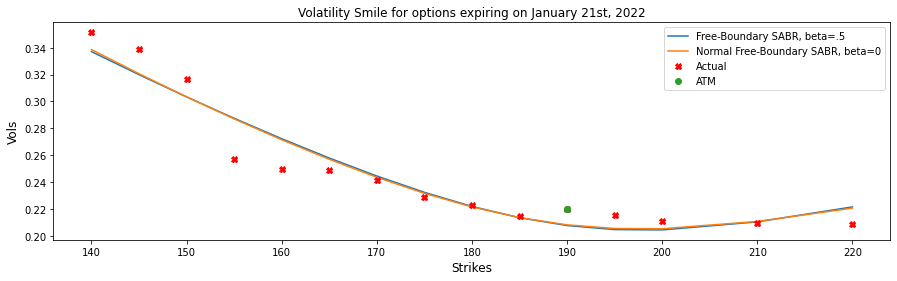

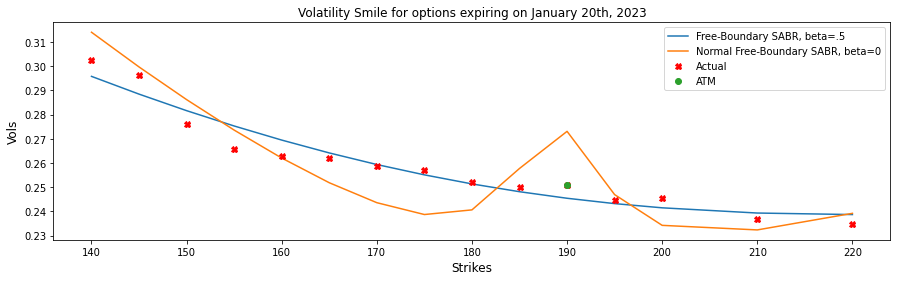

In [46]:
# Free-Boundary SABR Volatility model

freeSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, method="floch-kennedy", label="Free-Boundary SABR, beta=.5")
freeSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, method="floch-kennedy", label="Normal Free-Boundary SABR, beta=0")

SABRComparison([freeSABR_beta5, freeSABR_beta0], title="Free-Boundary SABR")

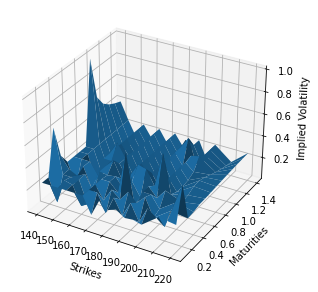

In [47]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
#if does not work use NoExceptLocalVolSurface
# local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .25)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, funct='localVol')


In [67]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

# Model1
m1_params = (0.02,0.2,0.5,0.1,0.01) if dataframe != "SPX" else (0.05,0.2,0.5,0.1,0.09)
# Model2
m2_params = (0.06,0.3,0.2,0.2,0.02) if dataframe != "SPX" else (0.01,0.5,0.2,0.2,0.06)

class hestonModelSurface:
    def __init__(self, params, label=""):
        (self.v0, self.kappa, self.theta, self.sigma, self.rho) = params
        self.label = label
        self.hestonModel = None
        self.engine = None
        self.heston_helpers = None
        self.heston_vol_surface = None
        self.strks = None
        self.marketValue = None
        self.modelValue = None
        self.relativeError = None
        self.avgError = None

        self.initialize()

    def initialize(self):
        process = ql.HestonProcess(flat_ts, dividend_ts, 
                                ql.QuoteHandle(ql.SimpleQuote(current_price)), 
                                self.v0, self.kappa, self.theta, self.sigma, self.rho)
        self.hestonModel = ql.HestonModel(process)
        self.engine = ql.AnalyticHestonEngine(self.hestonModel) 

        self.heston_helpers = []
        black_var_surface.setInterpolation("bicubic")
        one_year_idx = -1 
        date = dates[one_year_idx]

        for j, s in enumerate(strikes):
            t = (date - today)
            p = ql.Period(t, ql.Days)
            sigma = vols[one_year_idx][j]

            helper = ql.HestonModelHelper(p, calendar, current_price, s, 
                                        ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                        flat_ts, 
                                        dividend_ts)
            helper.setPricingEngine(self.engine)
            self.heston_helpers.append(helper)

        lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
        self.hestonModel.calibrate(self.heston_helpers, lm, 
                        ql.EndCriteria(500, 300, 1.0e-8, 1.0e-8, 1.0e-8))
        self.v0, self.kappa, self.theta, self.sigma, self.rho = self.hestonModel.params()

        self.set_surface()
        self.compute_errors()

    def set_surface(self):
        # Boilerplate to get to the Vol Surface object
        heston_handle = ql.HestonModelHandle(self.hestonModel)
        self.heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

    def compute_errors(self):
        # Statistical analysis on the Heston model and plotting

        self.strks, self.marketValue, self.modelValue, self.relativeError = ([], [], [], [])

        self.avgError = 0
        for i, opt in enumerate(self.heston_helpers):
            err = (opt.modelValue()/opt.marketValue() - 1.0)
            self.strks.append(strikes[i]); self.marketValue.append(opt.marketValue())
            self.modelValue.append(opt.modelValue())
            self.relativeError.append(100.0*(opt.modelValue()/opt.marketValue() - 1.0))
            self.avgError += abs(err)
        self.avgError = self.avgError*100.0/len(self.heston_helpers)

        self.to_dataframe()

    def to_dataframe(self):
        self.errors_dataframe = pd.DataFrame({"Strikes": self.strks, "Market Value": self.marketValue, "Model Value": self.modelValue, "Relative Error (%)": self.relativeError})
        self.var_dataframe = pd.DataFrame(data=[self.theta, self.kappa, self.sigma, self.rho, self.v0, self.avgError], index=["theta", "kappa", "sigma", "rho", "v0", "avgError"], columns=["Value"])


hestonModel1 = hestonModelSurface(m1_params, label="Model1")
hestonModel2 = hestonModelSurface(m2_params, label="Model2")


No handles with labels found to put in legend.


No handles with labels found to put in legend.


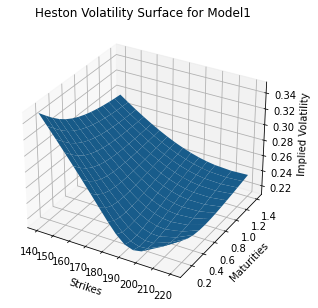

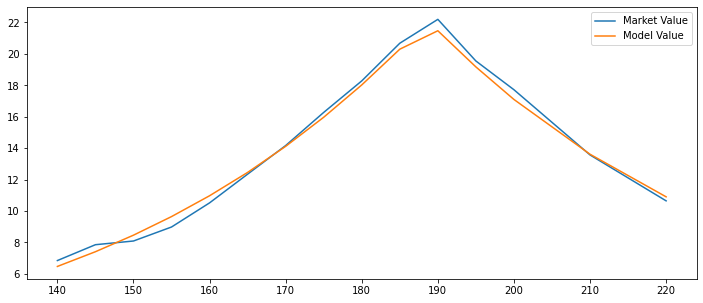

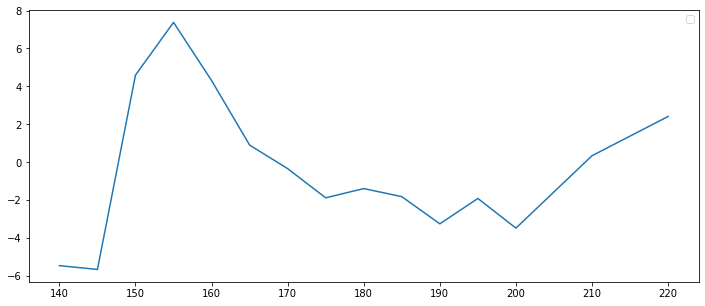

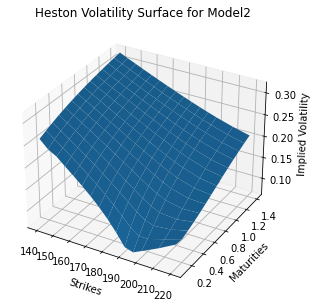

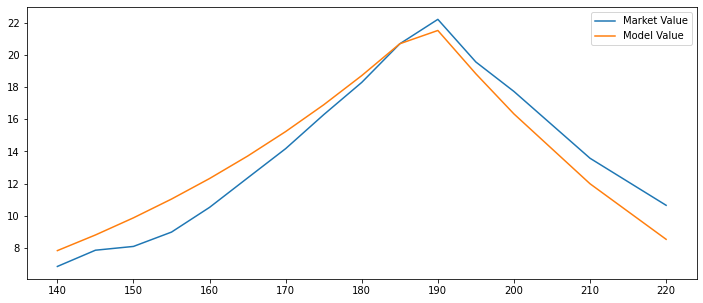

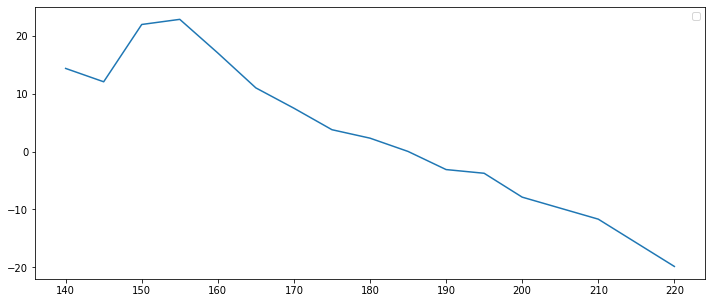

In [69]:
# HESTON Surface Plotting (Model1, Model2)

for model in (hestonModel1, hestonModel2):
    plot_vol_surface(model.heston_vol_surface, title="Heston Volatility Surface for {}".format(model.label))
    display(model.errors_dataframe.style.set_caption("{} calibration results".format(model.label))); display(model.var_dataframe.style.set_caption("{} parameters output".format(model.label)))

    fig1 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.marketValue, label="Market Value")
    plt.plot(model.strks, model.modelValue, label="Model Value")
    plt.title='Model1: Heston surface Market vs Model Value'; plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()
    fig2 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.relativeError)
    plt.title='Model1: Heston surface Relative Error (%)'; plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()

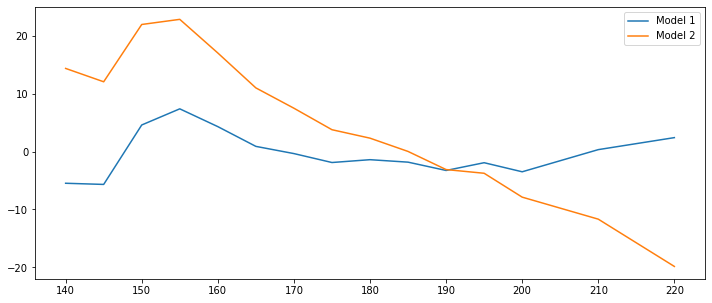

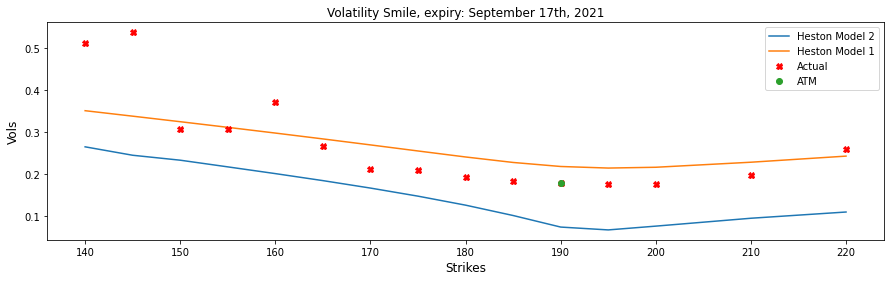

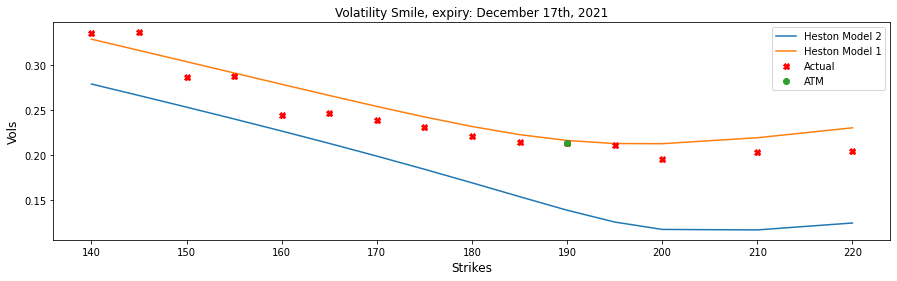

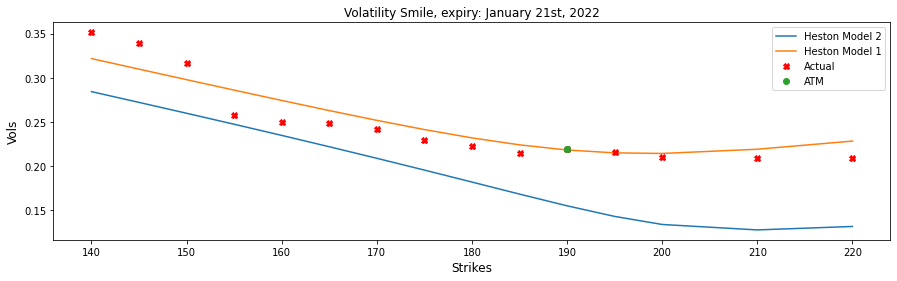

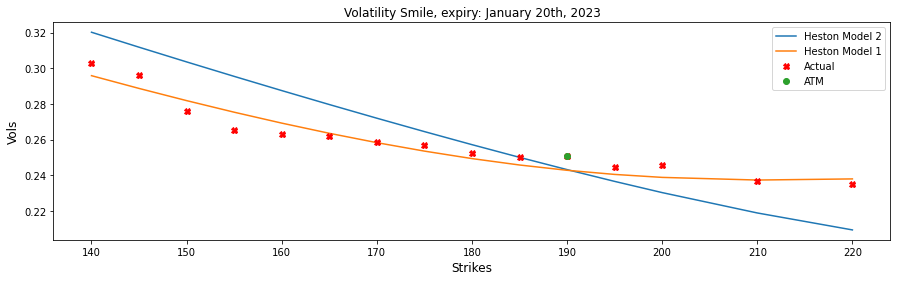

In [50]:
# Relative error comparison
plt.figure(figsize=plot_size)
plt.plot(hestonModel1.strks, hestonModel1.relativeError, label="Model 1")
plt.plot(hestonModel2.strks, hestonModel2.relativeError, label="Model 2")
plt.legend()

# Volatility smiles comparison
tenors = [dates[round((len(dates)-1) * x)] for x in (.2, .5, .75, 1)]
for tenor in tenors:
    l = [
        ([hestonModel2.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 2" ),
        ([hestonModel1.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 1" )
        ]
    plot_smile(tenor, l, market=True, title="Volatility Smile, expiry: {}".format(tenor))

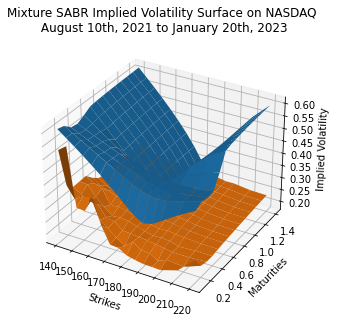

In [51]:
# MIXTURE SABR

class MixtureSABR:
    def __init__(self, zeroFB_SABR, nonzero_SABR):
        self.M = ql.Matrix(len(strikes), len(dates))
        self.zeroFB_SABR = zeroFB_SABR
        self.nonzero_SABR = nonzero_SABR
        
        self.initialize()

    def initialize(self):

        atm_index = strikes.tolist().index(ATM_price)

        for i in range(len(vols)):
            beta_FB = self.zeroFB_SABR.beta[i]
            nu_N = self.nonzero_SABR.nu[i]
            rho_N = self.nonzero_SABR.rho[i]
            
            for j in range(len(vols[i])):

                # sigma_0 = zeroFB_SABR.SABRVolMatrix[i][j] * math.log(current_price)**beta_FB
                # sigma_0 = nonzero_SABR.SABRVolMatrix[i][j]
                sigma_0 = self.zeroFB_SABR.SABRVolMatrix[atm_index][i]
                p = sigma_0 * beta_FB / ( sigma_0 * beta_FB + abs(nu_N * rho_N) )
                sigma_FB = self.zeroFB_SABR.SABRVolMatrix[j][i]
                sigma_N = self.nonzero_SABR.SABRVolMatrix[j][i]

                self.M[j][i] = math.sqrt((p**2) * sigma_FB +( (1-p)**2) * sigma_N)

        self.vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, self.M, day_count)
        self.vol_surface.enableExtrapolation()

mixtureSABR = MixtureSABR(freeSABR_beta5, SABR_beta0)
title = "Mixture SABR Implied Volatility Surface on {}\n {} to {}".format(dataframe, today, dates[-1])
plot_vol_surface(vol_surface=[mixtureSABR.vol_surface, black_var_surface], plot_strikes=strikes, funct='blackVol', title=title)

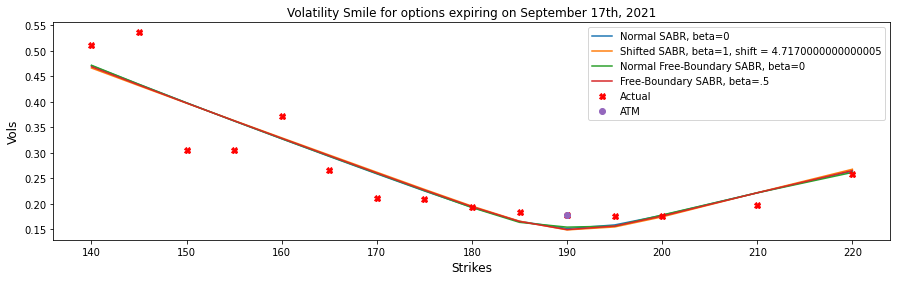

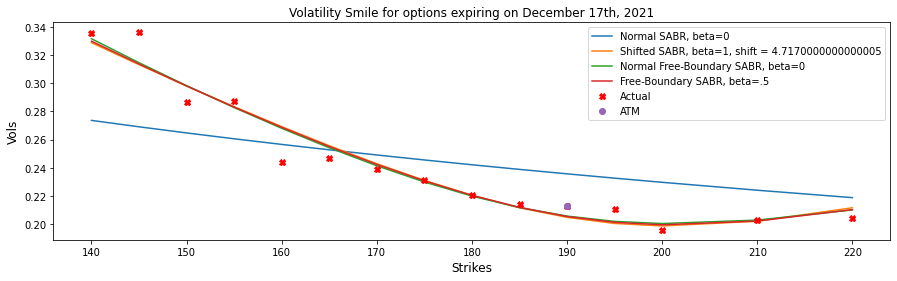

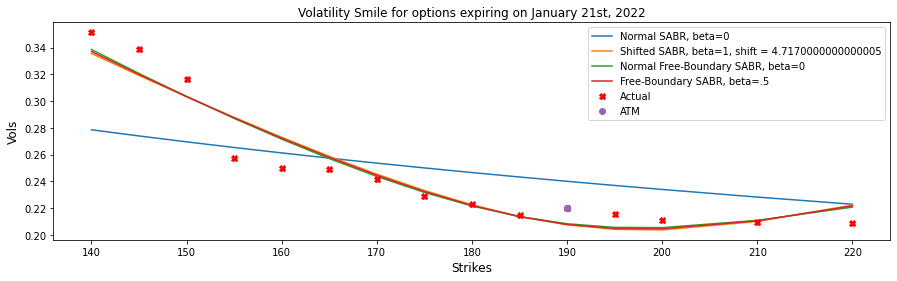

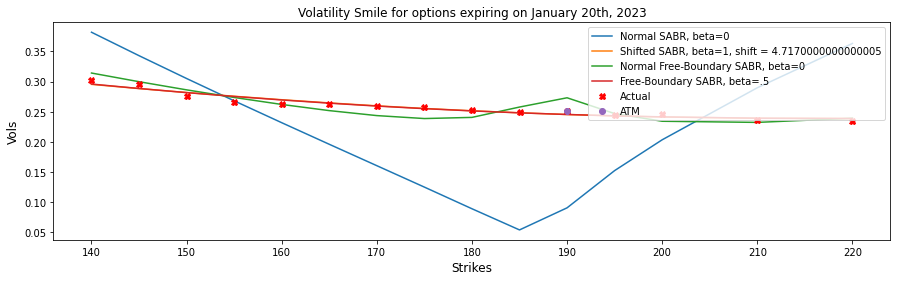

In [52]:
# VOLATILIY SMILES COMPARISON

models = (SABR_beta0, shiftedSABR_beta1, freeSABR_beta0, freeSABR_beta5)

smiles_comparison(models)

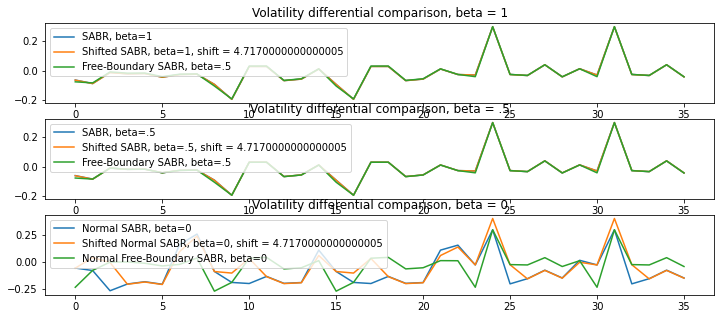

In [53]:
# Volatility differential comparison

def volDiffMatrix(model, part=1.):
    m = []
    for a in range(len(dates)):
        for b in range(len(strikes)):
            m.append(model.SABRVolDiffMatrix[a][b])
    return m [:round((len(m)-1) * part)]

fig, axs = plt.subplots(3, 1, figsize=plot_size)
for model in (SABR_beta1, shiftedSABR_beta1, freeSABR_beta5):
    v = volDiffMatrix(model, .3)
    axs[0].plot(v, label=model.label)
    axs[0].set_title("Volatility differential comparison, beta = 1")
axs[0].legend()

for model in (SABR_beta5, shiftedSABR_beta5, freeSABR_beta5):
    v = volDiffMatrix(model, .3)
    axs[1].plot(v, label=model.label)
    axs[1].set_title("Volatility differential comparison, beta = .5")
axs[1].legend()

for model in (SABR_beta0, shiftedSABR_beta0, freeSABR_beta0):
    v = volDiffMatrix(model, .3)
    axs[2].plot(v, label=model.label)
    axs[2].set_title("Volatility differential comparison, beta = 0")
axs[2].legend()


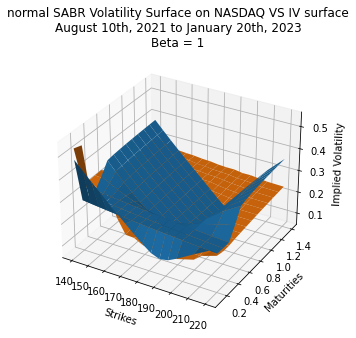

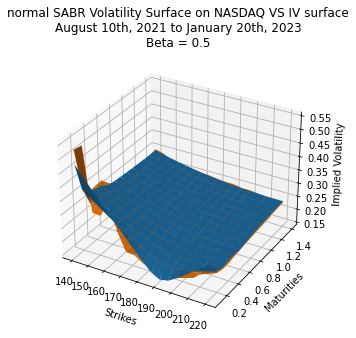

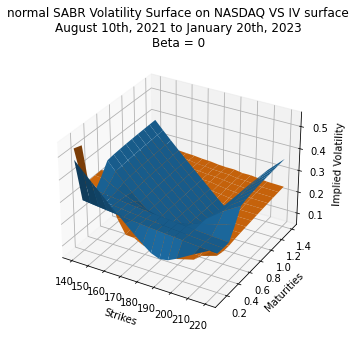

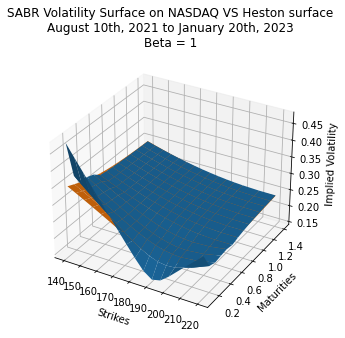

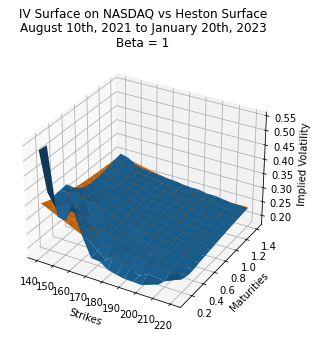

In [54]:
# Volatility Surfaces plots comparison

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0.5".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta5.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "SABR Volatility Surface on {} VS Heston surface\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta1.vol_surface, hestonModel1.heston_vol_surface], title=title)

title = "IV Surface on {} vs Heston Surface\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface([black_var_surface, hestonModel1.heston_vol_surface], title=title)